# Logistic Regression and Gradient Descent

The file LRTrain.csv contains information from 300 images of malignant (i.e. cancerous) and
benign (i.e., non-cancerous) breast tissue. The data set describes attributes of the cell nuclei in
each image. Each row of the dataset corresponds to one image. For each image, ten different
attributes related to the cell nuclei are recorded:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter2/ area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (a measure of how “complex” the perimeter is)

Because each image contains multiple cell nuclei, three quantities are measured for each of the 10
attributes above: the mean, standard error, and worst case value. This results in a total of 30
features for each image. The goal of this assignment is to train a logistic regression classifier using
gradient descent, which will then be used to predict whether or not each image was taken from
cancerous tissue.


<img src="image.png">

We can minimize the cost function using the Gradient Descent algorithm where we differentiate the cost function to move in the direction of the global minima point. We need to calculate the gradient at a point w for the negative log likelihood function which is:

$\frac{1}{n} \sum_{i=1}^{n} (\frac{1}{1+ \exp^{{-w}^Tx_i}} - y_i).x_i$

We can use a step size to update the weights accordingly.

$ x(i+1) = x(i) - (step\ size)* \frac{dy}{dx} $

Check if $|{\frac{dy}{dx}}| \le \epsilon$ and terminate if yes. Otherwise increment $i$ and return to previous steps mentioned

In [3]:
# import gurobi and numpy
from gurobipy import *
import numpy as np
from numpy import genfromtxt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [4]:
df_train = pd.read_csv('LRTrain.csv')
df_test = pd.read_csv('LRTest.csv')

In [5]:
df_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,12.180,20.52,77.22,458.7,0.08013,0.04038,0.02383,0.01770,0.1739,0.05677,...,32.84,84.58,547.8,0.1123,0.08862,0.1145,0.07431,0.2694,0.06878,0
1,15.280,22.41,98.92,710.6,0.09057,0.10520,0.05375,0.03263,0.1727,0.06317,...,28.03,113.80,973.1,0.1301,0.32990,0.3630,0.12260,0.3175,0.09772,1
2,14.760,14.74,94.87,668.7,0.08875,0.07780,0.04608,0.03528,0.1521,0.05912,...,17.93,114.20,880.8,0.1220,0.20090,0.2151,0.12510,0.3109,0.08187,0
3,14.190,23.81,92.87,610.7,0.09463,0.13060,0.11150,0.06462,0.2235,0.06433,...,34.85,115.00,811.3,0.1559,0.40590,0.3744,0.17720,0.4724,0.10260,1
4,9.876,19.40,63.95,298.3,0.10050,0.09697,0.06154,0.03029,0.1945,0.06322,...,26.83,72.22,361.2,0.1559,0.23020,0.2644,0.09749,0.2622,0.08490,0


In [6]:
y_train = df_train['diagnosis'].to_numpy()
X_train = df_train.drop('diagnosis', axis=1).to_numpy()
y_test = df_test['diagnosis'].to_numpy()
X_test = df_test.drop('diagnosis', axis=1).to_numpy()

In [7]:
n = 300
d = 30
gamma = 0.00003
epsilon = 0.1

In [8]:
w = np.zeros(d)
total_grad = 0

#### Define function for calculating the gradient

In [9]:
def gradient_function(w, X_train, y_train):
    n = len(X_train)
    d = len(w)
    sum_of_grad = np.zeros(d)
    
    for i in range(n):
        x_i = X_train[i]
        y_i = y_train[i]
        to_add = ((1/(1+np.exp(-1 * np.dot(w, x_i), dtype=np.float128))) - y_i) * x_i
        sum_of_grad += to_add
    grad = sum_of_grad/n
    return grad

#### Define function for computing weights for logistic regression 

In [10]:
def logistic_regression(w, X_train, y_train, iters, step, epsilon):
    num_iter = 0
    grad = gradient_function(w, X_train, y_train)
    w = w - step * grad
    
    # Calculate weights till tolerance is reached or the maximum number of iterations
    for i in range(iters):
        grad = gradient_function(w, X_train, y_train)
        w = w - step * grad
        if np.absolute(np.linalg.norm(grad)) < epsilon:
            print(f'Tolerance reached, stopped after {i+1} iterations')
            break
        grad_mag = np.absolute(np.linalg.norm(grad))
    print(f'The Gradient Norm after {i+1} iterations with Gamma = {step}, tolerance = {epsilon} is {round(grad_mag,2)}')
    return w

In [11]:
def calc_pred_proba(w, X):
    prob = 1/(1 + np.exp(-1 * np.dot(w, X)))
    return prob

In [12]:
def predict_classes(predicted, threshold):
    result = []
    for i in range(len(predicted)):
        if predicted[i] <= threshold:
            result.append(0)
        else:
            result.append(1)
    return result

In [13]:
def calc_metrics(actual, predicted):          
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(len(actual)):
        if ((predicted[i] == 1) & (actual[i] == 1)):
            tp = tp + 1
        elif ((predicted[i] == 1) & (actual[i] == 0)):
            fp = fp + 1
        elif ((predicted[i] == 0) & (actual[i] == 0)):
            tn = tn + 1
        elif ((predicted[i] == 0) & (actual[i] == 1)):
            fn = fn + 1
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fnr = 1 - tpr
    fpr = 1 - tnr
    a = (tp + tn)/len(actual)
    return round(tpr,3), round(fpr,3) , round(tnr,3), round(fnr,3)

#### Using different combination of max iterations, step sizes, and tolerances

In [14]:
combinations = {
    'step_size': [0.00001, 0.00005, 0.000001],
    'tolerance': [0.01, 0.001, 0.0001],
    'max_iterations': [2000, 3000, 5000]
}
df_iteration = pd.DataFrame(None, columns=["step_size", "tolerance", "max_iterations", "recall", "accuracy"])

In [15]:
# Looping over all combinations of termination criteria
for i in combinations['step_size']:
    for j in combinations['tolerance']:
        for k in combinations['max_iterations']:
            w = np.zeros(d)
            weight = logistic_regression(w, X_train, y_train, k, i, j)
            pred_proba = calc_pred_proba(X_train, weight)
            y_pred = predict_classes(pred_proba, 0.5)

            # Calculate the recall and accuracy of the model on the train data
            recall = recall_score(y_train, y_pred)
            accuracy = accuracy_score(y_train, y_pred)
            temp = pd.DataFrame([[i, k, j, accuracy, recall]],
                                   columns=["step_size",  "max_iterations", "tolerance", "accuracy", "recall",])
            df_iteration = pd.concat([df_iteration, temp], axis=0).reset_index(drop=True)

The Gradient Norm after 2000 iterations with Gamma = 1e-05, tolerance = 0.01 is 1.19
The Gradient Norm after 3000 iterations with Gamma = 1e-05, tolerance = 0.01 is 0.79
The Gradient Norm after 5000 iterations with Gamma = 1e-05, tolerance = 0.01 is 0.47
The Gradient Norm after 2000 iterations with Gamma = 1e-05, tolerance = 0.001 is 1.19
The Gradient Norm after 3000 iterations with Gamma = 1e-05, tolerance = 0.001 is 0.79
The Gradient Norm after 5000 iterations with Gamma = 1e-05, tolerance = 0.001 is 0.47
The Gradient Norm after 2000 iterations with Gamma = 1e-05, tolerance = 0.0001 is 1.19
The Gradient Norm after 3000 iterations with Gamma = 1e-05, tolerance = 0.0001 is 0.79
The Gradient Norm after 5000 iterations with Gamma = 1e-05, tolerance = 0.0001 is 0.47
The Gradient Norm after 2000 iterations with Gamma = 5e-05, tolerance = 0.01 is 0.73
The Gradient Norm after 3000 iterations with Gamma = 5e-05, tolerance = 0.01 is 0.68
The Gradient Norm after 5000 iterations with Gamma = 5e-

In [16]:
df_iteration = df_iteration.sort_values(by=['accuracy', 'recall'], ascending=[False, False])
df_iteration.head()

,step_size,tolerance,max_iterations,recall,accuracy
10,0.00005,0.0100,3000,0.850877,0.916667
13,0.00005,0.0010,3000,0.850877,0.916667
16,0.00005,0.0001,3000,0.850877,0.916667
9,0.00005,0.0100,2000,0.850877,0.913333
11,0.00005,0.0100,5000,0.850877,0.913333


We have best recall score when step size = 0.00005, max_iterations = 3000

In [17]:
w = np.zeros(d)
weight = logistic_regression(w, X_train, y_train, 3000, 0.00005, 0.01)

The Gradient Norm after 3000 iterations with Gamma = 5e-05, tolerance = 0.01 is 0.68


In [18]:
dict_coeff = {'Features':df_train.iloc[:,:-1].columns.values.tolist(), 'Coefficients': weight }
df_coeff = pd.DataFrame(dict_coeff)
df_coeff

,Features,Coefficients
0,radius_mean,-0.020186
1,texture_mean,-0.017039
2,perimeter_mean,-0.104330
3,area_mean,-0.029616
4,smoothness_mean,-0.000100
5,compactness_mean,0.000458
6,concavity_mean,0.000871
7,concave points_mean,0.000356
8,symmetry_mean,-0.000246
9,fractal_dimension_mean,-0.000113


### Modeling

In [19]:
pred_proba = calc_pred_proba(X_test, weight)

In [20]:
thresholds = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [21]:
metrics = []
for threshold in thresholds:
    y_pred = predict_classes(pred_proba, threshold)
    tpr, fpr, tnr, fnr = calc_metrics(y_test, y_pred)
    metrics_dict = {'Threshold':threshold, 'TPR':tpr, 'FPR':fpr, 'TNR':tnr, 'FNR':fnr}
    metrics.append(metrics_dict)

In [22]:
df_metrics = pd.DataFrame(metrics)
df_metrics

,Threshold,TPR,FPR,TNR,FNR
0,0.0,1.000,1.000,0.000,0.000
1,0.1,0.959,0.205,0.795,0.041
2,0.2,0.918,0.123,0.877,0.082
3,0.3,0.898,0.105,0.895,0.102
4,0.4,0.878,0.064,0.936,0.122
5,0.5,0.878,0.047,0.953,0.122
6,0.6,0.867,0.041,0.959,0.133
7,0.7,0.867,0.041,0.959,0.133
8,0.8,0.847,0.029,0.971,0.153
9,0.9,0.827,0.012,0.988,0.173


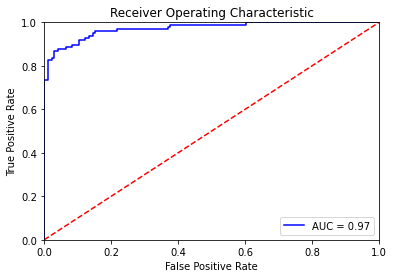

In [27]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = calc_pred_proba(X_test, weight)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()